In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

In [2]:
# jedi 0.14.1 tab completion fails; will be fixed in 0.14.2
import jedi
if jedi.__version__ == '0.14.1':
    %config Completer.use_jedi = False
    
# Progress bar
from tqdm.auto import trange, tqdm

In [4]:
import pynrc
from pynrc import nircam_dark

from astropy.io import fits

# Initialize SCA Dark

In [4]:
datadir='/Users/jarron/NIRCam/Data/CV3_Darks/'
outdir='/Users/jarron/NIRCam/dark_analysis/CV3/'
dark_data = nircam_dark(485, datadir, outdir)

[     pynrc:INFO] Initializing SCA 485/A5


In [5]:
# Dark ramp/slope info

# Get Super dark ramp (cube)
dark_data.get_super_dark_ramp()

# Calculate dark slope image
dark_data.get_dark_slope_image()
dark_data.get_super_bias_update()

# Calculate pixel slope averages
dark_data.get_pixel_slope_averages()

# Delete super dark ramp to save memory
del dark_data._super_dark_ramp
dark_data._super_dark_ramp = None

[     pynrc:INFO] Generating initial super bias
[     pynrc:INFO] Creating super dark ramp cube, updated super bias, and pixel mask info
[     pynrc:INFO] Calculating dark slope image...
[     pynrc:INFO] Opening updated super bias
[     pynrc:INFO] Calculating average pixel ramps...


In [6]:
# Calculate CDS Noise for various component 
# white noise, 1/f noise (correlated and independent), temporal and spatial
dark_data.get_cds_dict()

# Effective Noise
dark_data.get_effective_noise()

# Get kTC reset noise, IPC, and PPC values
dark_data.get_ktc_noise()

# Get the power spectrum information
# Saved to pow_spec_dict['freq', 'ps_all', 'ps_corr', 'ps_ucorr']
dark_data.get_power_spectrum(include_oh=False, calc_cds=True, mn_func=np.median, per_pixel=False)

[     pynrc:INFO] Building CDS Noise dictionaries...
[     pynrc:INFO]   Best fit excess variance model parameters: [1.41538086 7.78820259]
[     pynrc:INFO] Calculating kTC Noise for active and reference pixels...
[     pynrc:INFO] Building noise power spectrum dictionary...


In [7]:
# Calculate IPC/PPC kernels
dark_data.get_ipc(calc_ppc=True)
# Deconvolve the super dark and super bias images
dark_data.deconvolve_supers()

[     pynrc:INFO] Calculating IPC and PPC kernels...
[     pynrc:INFO]   IPC = 0.597% +/- 0.004%
[     pynrc:INFO]   PPC = 0.123% +/- 0.010%
[     pynrc:INFO] Deconvolving super dark and super bias images...


In [8]:
# Get column variations
dark_data.get_column_variations()
# Create dictionary of reference pixel behavior
dark_data.get_ref_pixel_noise()

[     pynrc:INFO] Determining column variations (RTN)
[     pynrc:INFO] Determining reference pixel behavior


# Simulate Ramps

In [9]:
from pynrc.simul.ngNRC import sim_dark_ramp, sim_image_ramp, sim_noise_data
from pynrc.simul.ngNRC import gen_ramp_biases, gen_col_noise
from pynrc.simul.ngNRC import add_ipc, add_ppc
from pynrc.reduce.calib import broken_pink_powspec, ramp_resample

In [10]:
from pynrc.simul.ngNRC import slope_to_ramps, simulate_detector_ramp

In [11]:
det = pynrc.DetectorOps(detector=485, ngroup=103, nint=1)#, ypix=256, xpix=256, wind_mode='WINDOW')

[     pynrc:INFO] Initializing SCA 485/A5


In [13]:
import datetime
pynrc.setup_logging('WARN')

dir_out = '/Users/jarron/NIRCam/Data/Sim_Darks/485/'
nfiles = 2

for i in trange(nfiles):
    now = datetime.datetime.now().isoformat()[:-7]
    file_out = dir_out + f'NRCNRCALONG-DARK-485_SE_{now}.fits'
    file_out = file_out.replace(':', 'h', 1)
    file_out = file_out.replace(':', 'm', 1)

    slope_to_ramps(det, dark_data, DMS=False, return_results=False, file_out=file_out)

pyNRC log messages of level WARN and above will be shown.
pyNRC log outputs will be directed to the screen.


In [63]:
data = simulate_detector_ramp(det, dark_data, im_slope=None, out_ADU=False)

[     pynrc:WARNING] Max ramp time 6.9 is less than ramp_avg_tf. Not applying ramp_avg_ch.


[     pynrc:INFO] Generating dark current ramp...
[     pynrc:INFO] Generating read noise...
[     pynrc:INFO] Adding correlated pink noise...
[     pynrc:INFO] Adding uncorrelated pink noise...
[     pynrc:INFO] Adding ACN noise...


In [46]:
# Detector setup and info
det = self.det

nchan = det.nout
ny, nx = (det.ypix, det.xpix)

# Super bias and darks
super_bias = self.super_bias_deconv # DN
super_dark = self.super_dark_deconv # DN/sec

# Scan direction info
ssd = self.det.same_scan_direction
rsd = self.det.reverse_scan_direction

# IPC/PPC kernel information
k_ipc = self.kernel_ipc
k_ppc = self.kernel_ppc

# Noise info
cds_dict = self.cds_act_dict
keys = ['spat_det', 'spat_pink_corr', 'spat_pink_uncorr']
cds_vals = [np.sqrt(np.mean(cds_dict[k]**2, axis=0)) for k in keys]
# CDS Noise values
rd_noise_cds, c_pink_cds, u_pink_cds = cds_vals
# Noise per frame
rn, cp, up = cds_vals / np.sqrt(2)

# kTC Reset Noise
ktc_noise = self.ktc_noise

# Detector Gain
gain = det.gain

# Power spectrum for correlated noise
freq = self.pow_spec_dict['freq']
scales = self._pow_spec_dict['ps_corr_scale']
# pcorr_fit = broken_pink_powspec(freq, scales)

# Reference info
ref_info = self.det.ref_info
ref_ratio = np.mean(self.cds_ref_dict['spat_det'] / self.cds_act_dict['spat_det'])

In [76]:
det_test = pynrc.DetectorOps(xpix=100,ypix=100,x0=10,y0=450,wind_mode='WINDOW')

[     pynrc:INFO] Initializing SCA 481/A1


In [99]:
det_test.reverse_scan_direction

False

In [ ]:
det_test.ref_info

In [101]:
ref_dict

{'master_bias_mean': 11793.712347773406,
 'master_bias_std': 17.48879600483141,
 'master_bias_f2f': 27.2516115791947,
 'amp_offset_mean': array([ 456.05125832,    2.17391779, -545.37722789, -435.528466  ]),
 'amp_offset_std': array([6.62611489, 6.46751904, 5.39775639, 5.11988701]),
 'amp_offset_f2f': array([23.2400516 , 20.53304719, 11.29430156, 11.73309175]),
 'master_amp_cf': array([[-6.66178200e+02, -1.86088687e+03, -2.37350164e+03,
         -3.26236006e+02],
        [ 9.51548949e-02,  1.57970682e-01,  1.55008394e-01,
         -9.26701087e-03]]),
 'amp_even_col_offset': array([-94.82853706, 652.50195607, 571.35198555, 408.98628419]),
 'amp_odd_col_offset': array([  94.3076215 , -652.95998228, -572.39932551, -414.77873753]),
 'amp_ref_inst_f2f': array([0.95398145, 1.26864837, 1.10981051, 0.93937857])}

(0, 20)

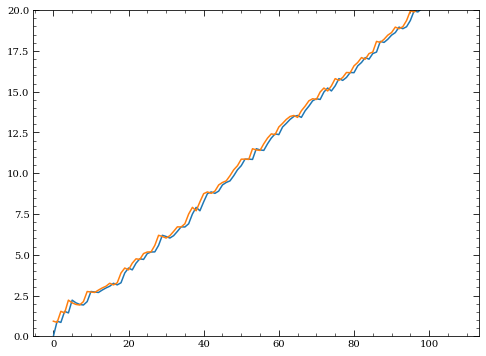

In [97]:
plt.plot(test[1])
plt.plot(test[1,1:])
plt.ylim([0,20])

In [71]:
res = np.random.poisson(10, (3,50,50))#.astype('float')

In [72]:
%time res = np.cumsum(res, axis=0, out=res)

CPU times: user 57 µs, sys: 3 µs, total: 60 µs
Wall time: 61.8 µs


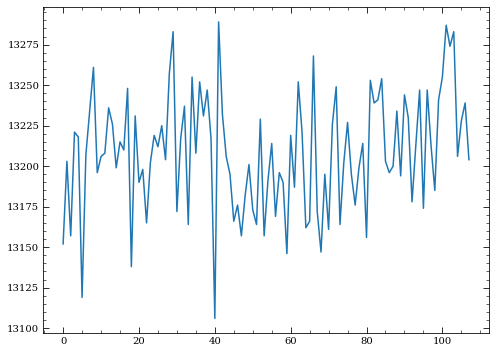

In [49]:
plt.plot(data[:,100,100])

In [38]:
data /= gain

In [31]:
col_noise.shape

(108, 1, 2048)

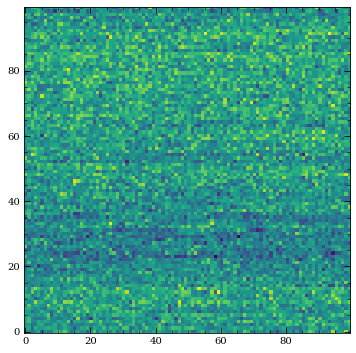

In [16]:
plt.imshow(data_noise[50,0:100,0:100])

In [17]:
super_bias = self.super_bias_deconv
super_dark = self.super_dark_deconv

k_ipc = self.kernel_ipc
k_ppc = self.kernel_ppc
# Scan direction info
ssd = self.det.same_scan_direction
rsd = self.det.reverse_scan_direction
# Average shape of ramp
ramp_avg_ch = self.dark_ramp_dict['ramp_avg_ch']

gain = self.det.gain
ktc_noise = self.ktc_noise # Units of DN

# Reference info
ref_info = self.det.ref_info
ref_ratio = np.mean(self.cds_ref_dict['spat_det'] / self.cds_act_dict['spat_det'])



In [ ]:
from pynrc.simul.ngNRC import gen_col_noise, add_col_noise, gen_ramp_biases
from pynrc.simul.ngNRC import pink_noise, fft_noise, sim_noise_data, gen_dark_ramp, sim_dark_ramp



In [ ]:
pbar = tqdm(total=10, leave=False)

# Initialize data with dark current 
pbar.set_description("Dark Current")
data = sim_dark_ramp(det, super_dark, gain=gain, ramp_avg_ch=ramp_avg_ch, ref_info=ref_info)
pbar.update(1)

# Add super bias
pbar.set_description("Super Bias")
data += super_bias
pbar.update(1)

# Add kTC noise:
pbar.set_description("kTC Noise")
ktc_offset = np.random.normal(scale=ktc_noise, size=(ny,nx))
data += ktc_offset
pbar.update(1)

# Apply IPC
pbar.set_description("Include IPC")
data = add_ipc(data, kernel=k_ipc)
pbar.update(1)

pbar.set_description("Detector Noise")
data += sim_noise_data(det, rd_noise=rn, u_pink=up, c_pink=cp*1.2,
                       acn=1, pow_spec_corr=pcorr_fit, ref_ratio=ref_ratio,
                       same_scan_direction=ssd, reverse_scan_direction=rsd)
pbar.update(1)

# Add reference offsets
pbar.set_description("Ref Pixel Instability")
ref_dict = self._ref_pixel_dict
data += gen_ramp_biases(ref_dict, data_shape=data.shape, ref_border=det.ref_info)
pbar.update(1)

# Add column noise
pbar.set_description("Column Noise")
col_noise = gen_col_noise(self.column_variations, self.column_prob_bad, nz=nz, nx=nx)
data += col_noise
pbar.update(1)

# Apply PPC
pbar.set_description("Include PPC")
data = add_ppc(data, nchans=nchan, kernel=k_ppc, in_place=True,
               same_scan_direction=ssd, reverse_scan_direction=rsd)
pbar.update(1)

# Convert to 16-bit int
data[data < 0] = 0
data[data >= 2**16] = 2**16 - 1
data = data.astype('uint16')

# Then back to float
data = data.astype(np.float)

# Ref pixel correction
pbar.set_description("Ref Pixel Correction")
data -= super_bias
data = reffix_hxrg(data, **kw_reffix)
pbar.update(1)

pbar.set_description("Calc Power Spectrum")
ps, _, _ = get_power_spec(data, nchan=nchan, calc_cds=True, kw_powspec=kw_powspec)
pbar.update(1)

ps_arr.append(ps)
pbar.close()


In [4]:
from pynrc import nrc_utils, robust

from pynrc.detops import create_detops
from pynrc.reduce.ref_pixels import reffix_hxrg, channel_smooth_savgol, channel_averaging
from pynrc.nrc_utils import jl_poly_fit, jl_poly, hist_indices
from pynrc.simul.ngNRC import gen_col_noise, add_col_noise, gen_ramp_biases
from pynrc.simul.ngNRC import pink_noise, fft_noise, sim_noise_data, gen_dark_ramp, sim_dark_ramp
from pynrc.simul.ngNRC import add_ipc, add_ppc

from pynrc.reduce.calib import get_ipc_kernel, ipc_deconvolve, ppc_deconvolve
from pynrc.reduce.calib import get_fits_data, gen_super_bias, gen_super_dark
from pynrc.reduce.calib import chisqr_red, ramp_derivative, gen_col_variations
from pynrc.reduce.calib import gen_ref_dict#, get_bias_offsets, get_oddeven_offsets, get_ref_instability
from pynrc.reduce.calib import nircam_dark, plot_dark_histogram
from pynrc.reduce.calib import pow_spec_ramp, fit_corr_powspec, broken_pink_powspec
from pynrc.reduce.calib import get_power_spec, get_freq_array

In [5]:
import os, gzip, json
from copy import deepcopy
from astropy.io import fits
from scipy import ndimage

In [4]:
# Initialize
datadir='/Users/jarron/NIRCam/Data/CV3_Darks/'
outdir='/Users/jarron/NIRCam/dark_analysis/CV3/'
dark_data = nircam_dark(485, datadir, outdir)

[     pynrc:INFO] Initializing SCA 485/A5
